# Evaluation

In [4]:
import nextbike.preprocessing.Preprocessing as prep
import nextbike.model.clustering.cluster as cluster
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import zscore
import numpy as np
from vincenty import vincenty 
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.svm import SVR
import time 

In [2]:
df_train = prep.get_trip_data("data/internal/dortmund.csv",with_weather=True)
df_test = prep.get_trip_data("data/internal/dortmund_test.csv",with_weather=True)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


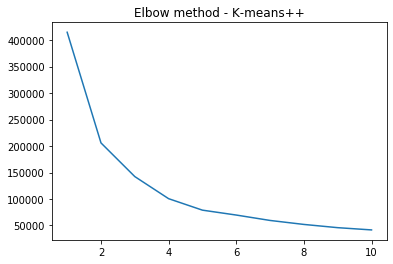

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


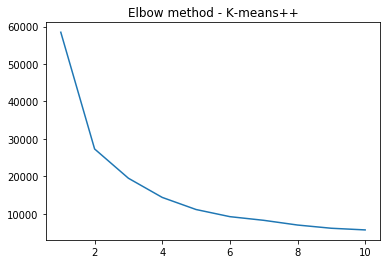

In [5]:
cluster_value_train = cluster.elbow_method(df_train)
cluster_value_test = cluster.elbow_method(df_test)
km = KMeans(n_clusters = 4)
km.fit(cluster_value_train["X_scaled"])
df_train["area_start"] = km.predict(cluster_value_train['X_scaled'])+1
df_test["area_start"] = km.predict(cluster_value_test['X_scaled'])+1

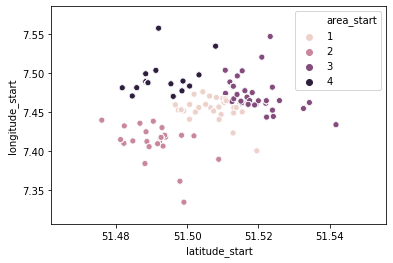

In [6]:
# train set 
sns.scatterplot("latitude_start", "longitude_start",hue="area_start",data=df_train)

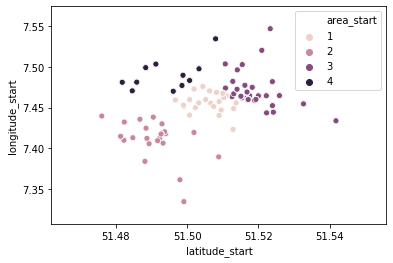

In [7]:
# test set (July)
sns.scatterplot("latitude_start", "longitude_start",hue="area_start",data=df_test)

In [43]:
X = df_train[["month","weekday","day_of_year","hour","minute","latitude_start","longitude_start",
        "area_start","temperature °C","precipitation", "distanceToUniversity","distanceToCentralStation"]]
y =df_train["trip_duration"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [45]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# parameter tuning done with RandomizedSearchCV (see in the notebook with RandomizedSearches)
rfr = RandomForestRegressor(max_features="auto",n_estimators=1155, max_depth=70, min_samples_split=10, min_samples_leaf=8,bootstrap=True)
rfr.fit(X_train_scaled,y_train)
pred = rfr.predict(X_test_scaled)
pred_train = rfr.predict(X_train_scaled)

print("w/o cross-validation:")
print("R^2-Score is: {}".format(rfr.score(X_train_scaled,y_train)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_train,pred_train))))
print("MAE: {}".format(mean_absolute_error(y_train,pred_train)))
print("")
print("w/ cross-validation")
print("R2-Score is: {}".format(rfr.score(X_test_scaled,y_test)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test,pred))))
print("MAE: {}".format(mean_absolute_error(y_test,pred)))

w/o cross-validation:
R^2-Score is: 0.43174602209030577
RMSE: 62.873084776050234
MAE: 26.295646535197847

w/ cross-validation
R2-Score is: 0.18479609459652713
RMSE: 75.32819027924414
MAE: 34.35505384322197


# Evaluating the model with the test set 

In [8]:
# not train test split 
# using the whole dataset as the test set 
X_train = df_train[["month","weekday","day_of_year","hour","minute","latitude_start","longitude_start",
        "area_start","temperature °C","precipitation", "distanceToUniversity","distanceToCentralStation"]]

y_train = df_train["trip_duration"]

# using the received test set as the test set (data for July)
X_test = df_test[["month","weekday","day_of_year","hour","minute","latitude_start","longitude_start",
        "area_start","temperature °C","precipitation", "distanceToUniversity","distanceToCentralStation"]]

y_test = df_test["trip_duration"]

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# parameter tuning done with RandomizedSearchCV (see in the notebook with RandomizedSearches)
rfr = RandomForestRegressor(max_features="auto",n_estimators=1155, max_depth=70, min_samples_split=10, min_samples_leaf=8,bootstrap=True)
rfr.fit(X_train_scaled,y_train)
pred = rfr.predict(X_test_scaled)
pred_train = rfr.predict(X_train_scaled)

print("w/o cross-validation:")
print("R^2-Score is: {}".format(rfr.score(X_train_scaled,y_train)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_train,pred_train))))
print("MAE: {}".format(mean_absolute_error(y_train,pred_train)))
print("")
print("w/ cross-validation")
print("R2-Score is: {}".format(rfr.score(X_test_scaled,y_test)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test,pred))))
print("MAE: {}".format(mean_absolute_error(y_test,pred)))

w/o cross-validation:
R^2-Score is: 0.4365382863914786
RMSE: 62.61380101150388
MAE: 26.06901748893567

w/ cross-validation
R2-Score is: -0.14335369317210422
RMSE: 89.58378260637706
MAE: 53.11407053976964


# Evaluation 
# Polynomial Regression 

In [ ]:
poly_reg = PolynomialFeatures(4)
x_poly = poly_reg.fit_transform(X_train)
model = Ridge()
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.transform(X_test))
y_pred_train = model.predict(x_poly)

print("w/o cross-validation:")
print("R^2-Score is: {}".format(r2_score(y_train, y_pred_train)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_train,y_pred_train))))
print("MAE: {}".format(mean_absolute_error(y_train,y_pred_train)))
print("")
print("w/ cross-validation:")
print ('The R^2 is: ',r2_score(y_test, y_pred))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))
print("MAE: {}".format(mean_absolute_error(y_test,y_pred)))  

--> In retrospect the Polynomial Regression of degree 4 returns better results than the chosen Random Forest Regressor